In [2]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

In [3]:
def display_image(img):
    plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
    plt.axis("off")

def overlay_fixed_moving(fixed, moving):
    img1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    img2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    cimg = sitk.Compose(img1, img2, sitk.Cast(img1/2. + img2/2., sitk.sitkUInt8))
    plt.imshow(sitk.GetArrayFromImage(cimg))
    plt.axis("off")

# Groupwise Registration

Groupwise registration methods try to mitigate uncertainties associated with any one image by simultaneously registering all images in a population. This incorporates all image information in registration process and eliminates bias towards a chosen reference frame. The method described here uses a 3D (2D+time) and 4D (3D+time) free-form B-spline deformation model and a similarity metric that minimizes variance of intensities under the constraint that the average deformation over images is zero. This constraint defines a true mean frame of reference that lie in the center of the population without having to calculate it explicitly.

The method can take into account temporal smoothness of the deformations and a cyclic transform in the time dimension. This may be appropriate if it is known a priori that the anatomical motion has a cyclic nature e.g. in cases of cardiac or respiratory motion.

Note that brain registration is a difficult to task because of complex anatomical variations and almost a scientific topic in itself. Entire registration packages are dedicated to just brain image processing. In this section we are less strict with the end result and focus on illustrating the groupwise registration method in SimpleElastix.

In [4]:
dataPath = os.path.join(os.sep, "Users", "tannersorensen", "SimpleElastix-fork", \
                        "SimpleElastix-build", "SimpleITK-build", "ExternalData", \
                        "Testing", "Data", "Input")

fixedFilename = "BrainProtonDensitySliceShifted13x17y.png"
fixedImage = sitk.ReadImage(os.path.join(dataPath, fixedFilename), sitk.sitkUInt8)

movingFilename = "BrainProtonDensitySliceR10X13Y17.png"
movingImage = sitk.ReadImage(os.path.join(dataPath, movingFilename), sitk.sitkUInt8)

Consider the following mean image:

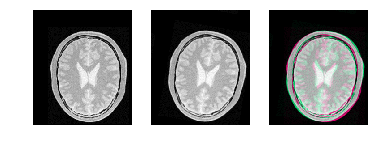

In [5]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# moving image
plt.subplot(1,3,2)
display_image(movingImage)

# fixed image (red) and moving image (green),
# with overlap in white
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, movingImage)

Elastix takes a single N+1 dimensional image for groupwise registration. Therefore we need to first concatenate the images along the higher dimension. SimpleITK makes this very easy with the `JoinSeries` image filter. The registration step is business as usual:

In [9]:
# Concatenate the ND images into one (N+1)D image
population = [movingFilename, movingFilename, movingFilename, movingFilename]
vectorOfImages = sitk.VectorOfImage()

for filename in population:
  vectorOfImages.push_back(sitk.ReadImage(os.path.join(dataPath, filename), sitk.sitkUInt8))

image = sitk.JoinSeries(vectorOfImages)

# Register
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(image)
elastixImageFilter.SetMovingImage(image)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap('groupwise'))
elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1054bb960> >

While the groupwise transform works only on the moving image we need to pass a dummy fixed image is to prevent elastix from throwing errors. This does not consume extra memory as only pointers are passed internally.

The result image is shown in Figure 13. It is clear that anatomical correpondence is obtained in many regions of the brain. However, there are a some anatomical regions that have not been registered correctly, particularly near Corpus Collosum. Generally these kinds of difficult registration problems require a lot of parameter tuning. No way around that. In a later chapter we introduce methods for assessment of registration quality.

---

#### Tip

We can use the `JoinSeries()` SimpleITK method to construct a 4D image from multiple 3D images and the `Extract()` SimpleITK method to pick out a 3D image from a result 4D image.

Note that the `JoinSeries` method may throw an error “Inputs do not occupy the same physical space!” if image information is not perfectly aligned. These can be caused by slight differences between the image origins, spacing, or axes. The tolerance that SimpleITK uses for these settings can be adjusted using `sitk.ProcessObject.SetGlobalDefaultDirectionTolerance(x)` and `sitk.ProcessObject.SetGlobalDefaultCoordinateTolerance(x)`. We may need to change the image origins to make sure they are the same. This can be done by copying the origin of one of the images `origin = firstImage.GetOrigin()` and setting it to the others `otherImages.SetOrigin(origin)`

---